<a href="https://colab.research.google.com/github/callmeeric5/Epita_AIS/blob/main/Deep_Learning/assignment/practical_work_3/pw_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Models (DDPM) Practical Work

## Imports

This forces Jupyter to reload all `.py` files that you are using on the side. Otherrwise it'll load them once and if you modify the code in the your `.py` files you'll have to reload your kernel for the changes to be reloaded.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

In [3]:
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load the Dataset

In [4]:
!pip install datasets

In [5]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for fashion_mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fashion_mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision.transforms import Compose

# define image transformations (e.g. using torchvision)
transform = Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)


# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image) for image in examples["image"]]
    del examples["image"]

    return examples


transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(
    transformed_dataset["train"], batch_size=batch_size, shuffle=True
)

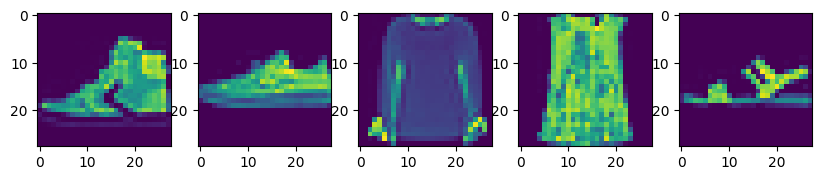

In [7]:
feature = next(iter(dataloader))
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, i in zip(axes, range(5)):
    ax.imshow(feature["pixel_values"][i].permute(1, 2, 0))

## Implement the Denoising Diffusion Process

### Implement the Beta Schedule

#### Linear Beta Schedule

In [8]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

#### Cosine Beta Schedule

In [9]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    t = torch.linspace(0, timesteps - 1, timesteps)
    f = torch.cos((t / timesteps + s) / (1 + s) * torch.pi / 2) ** 2
    beta = 1 - f / f[0]
    return torch.clip(beta, 0.0001, 0.9999)

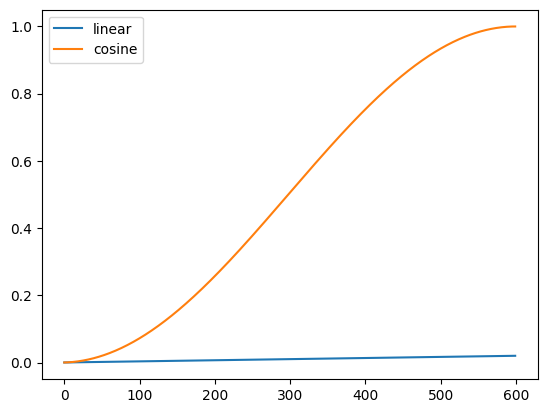

In [10]:
timesteps = 600

beta_linear = linear_beta_schedule(timesteps)
beta_cosine = cosine_beta_schedule(timesteps)

plt.plot(beta_linear, label="linear")
plt.plot(beta_cosine, label="cosine")
plt.legend()
plt.show()

### Constants

In [11]:
timesteps = 600

# define beta schedule
betas = linear_beta_schedule(
    timesteps=timesteps
)  # or `cosine_beta_schedule(timesteps=timesteps)`

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# This is just the previous step of the cumulative product above
# It's just alphas_cumprod without the last value and with a 1.0 padding at the beginning
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = (1 - alphas_cumprod_prev) / (1 - alphas_cumprod) * betas

In [12]:
posterior_variance.shape

torch.Size([600])

### Inference

In [18]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [19]:
@torch.no_grad()
def p_sample(model, x_t, ts, current_t):
    """
    model: Our model we'll create later
    x_t: The noisy image of current time_step `t`
    ts: All the $t$ for the current time step, basically an array with only `t` times the batch size. Remember that we are always computing our formulas for multiple images at the same time (aka all imaages in the batch).
    current_t: The $t$ integer value from the `ts` array. It's more convenient to have by itself if we want to do the if condition we saw. You could also take the first (or any other) value from the `ts` array, but less convenient.
    """

    # Extract the current time step constants `*_t` here

    # COMPLETE THIS
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, ts, x_t.shape)
    betas_t = extract(betas, ts, x_t.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, ts, x_t.shape
    )

    mean_t = sqrt_recip_alphas_t * (
        x_t - betas_t * model(x_t, ts) / sqrt_one_minus_alphas_cumprod_t
    )

    # The condition line 3 in the algorithm
    if current_t == 0:
        # `if t = 0: z = 0` so we can just return the `mean_t`
        return mean_t
    else:
        # COMPLETE THIS
        posterior_variance_t = extract(posterior_variance, ts, x_t.shape)
        z = torch.randn_like(x_t)

        return mean_t + posterior_variance_t * z

In [20]:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    batch_size = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for t in tqdm(
        reversed(range(0, timesteps)), desc="sampling loop time step", total=timesteps
    ):
        # torch.full: Creates a tensor of size size filled with value i
        img = p_sample(
            model, img, torch.full((batch_size,), t, device=device, dtype=torch.long), t
        )
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

### Training Loss

In [21]:
from utils import generate_transform_tensor_to_pil_image


# forward diffusion
def q_sample(x_0, ts, noise=None):
    """
    x_0: The original image that we want to add noise to given the specific beta schedule we precomputed above
    ts: All the $t$ for the current time step, basically an array with only `t` times the batch size. Remember that we are always computing our formulas for multiple images at the same time (aka all imaages in the batch).
    """

    if noise is None:
        noise = torch.randn_like(x_0)

    # COMPLETE THIS
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, ts, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, ts, x_0.shape
    )

    # The red rectangle part in our formula
    model_input = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    return model_input

In [22]:
# This function is already made for you, it computes the full loss from the training loop above using your implementation of `q_sample` (the red rectangle part)
# You can choose between 3 loss types, "l1", "l2" (or Mean Squared Error (MSE), like in the paper) or "huber" (or smooth l1) loss.
def p_losses(denoise_model, x_0, t, noise=None, loss_type="l1"):
    # The noise `epsilon` in our equation to which we compare our model noise prediction
    if noise is None:
        noise = torch.randn_like(x_0)

    # This is where `q_sample` is being used
    # `x_noisy` is basically our model input
    x_noisy = q_sample(x_0=x_0, ts=t, noise=noise)

    # epsilon_theta from our formula in the green rectangle
    predicted_noise = denoise_model(x_noisy, t)

    # The `|| epsilon - epsilon_theta ||^2` part of the equation
    # The derivative part is only computed later in the training loop by PyTorch as we've been doing for all our models up until now
    # You can choose between 3 losses, L2/MSE loss is the one from the paper
    if loss_type == "l1":
        # Same as L1 without the power of 2
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == "l2":
        # The loss in the paper
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        # The Huber loss might be slightly better in this case
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        # If we input any another loss
        raise NotImplementedError()

    # Return the final loss value
    return loss

In [24]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 717.1 kB/s eta 0:00:00


## Define the model

In [25]:
from torch.optim import AdamW

from model import Unet

device = "cuda" if torch.cuda.is_available() else "cpu"


model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(
        1,
        2,
        4,
    ),
    use_convnext=False,  # You can experiment with the other architecture that uses ConvNext
    resnet_block_groups=1,  # Set this to 1 for ResNet and 8 for ConvNext
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)

## Training loop

Loss: 0.475387841463089
Loss: 0.07502918690443039
Loss: 0.04401135817170143
Loss: 0.03954505920410156
Loss: 0.037475842982530594


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

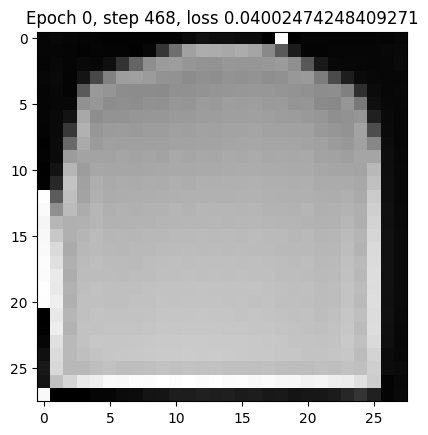

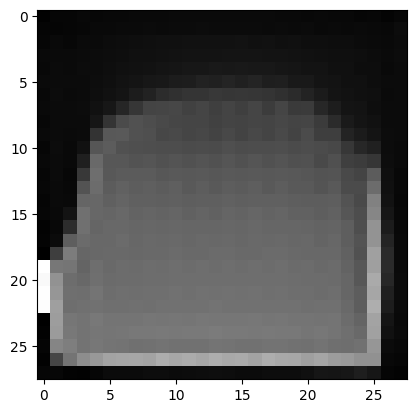

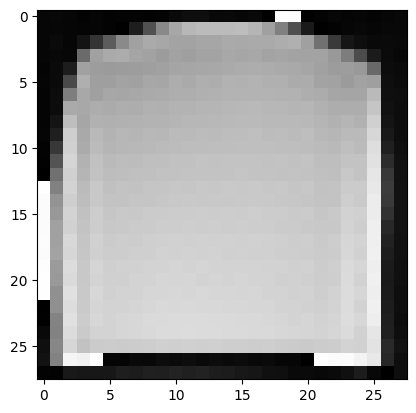

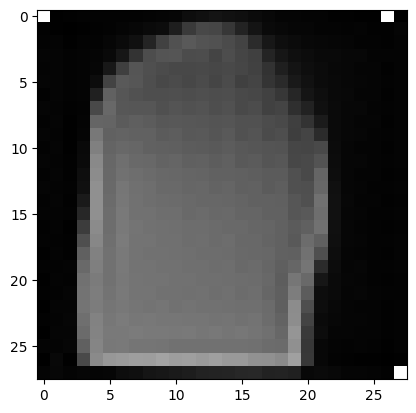

Loss: 0.03620543330907822
Loss: 0.03246733546257019
Loss: 0.03809220716357231
Loss: 0.030936328694224358
Loss: 0.035187724977731705


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

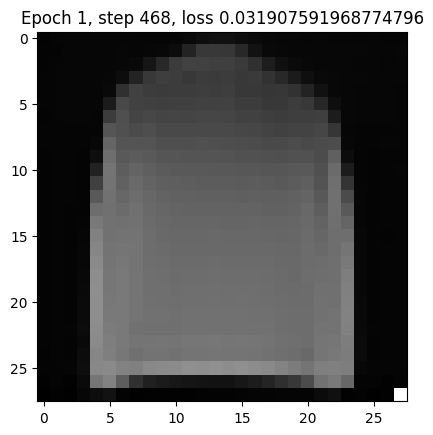

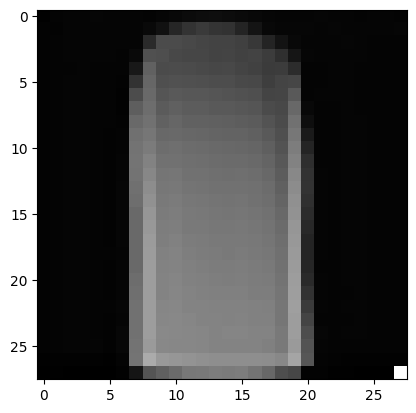

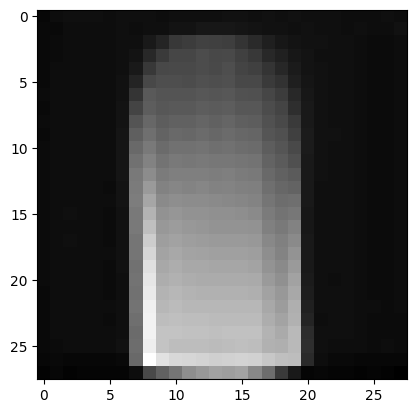

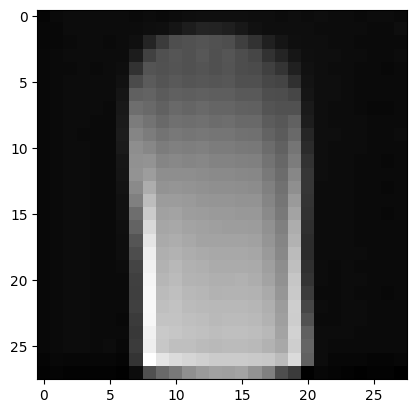

Loss: 0.029649008065462112
Loss: 0.03337709233164787
Loss: 0.027159694582223892
Loss: 0.03388221934437752
Loss: 0.025783849880099297


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

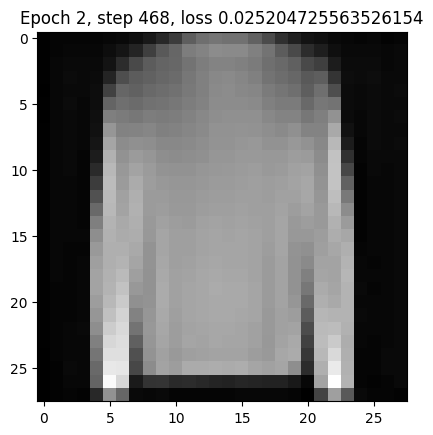

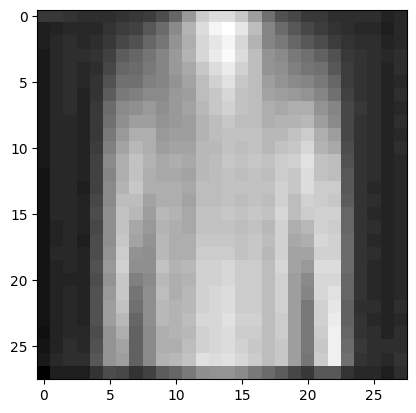

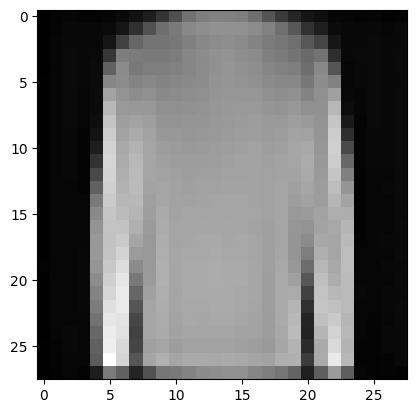

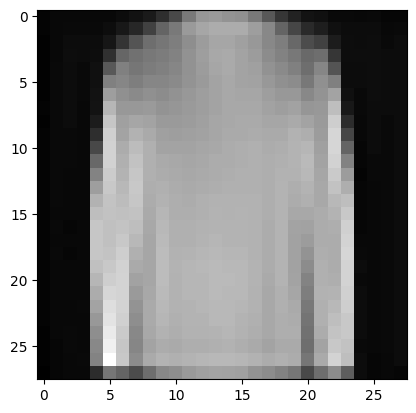

Loss: 0.034648630768060684
Loss: 0.03417283669114113
Loss: 0.02794444002211094
Loss: 0.030376959592103958
Loss: 0.020275210961699486


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

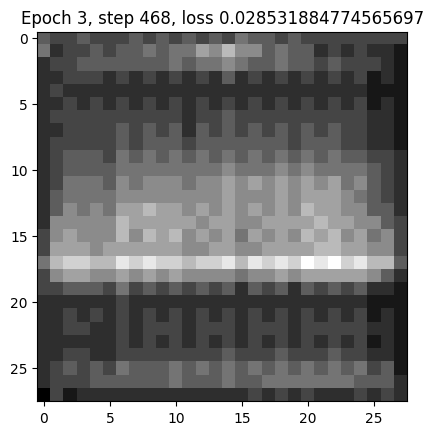

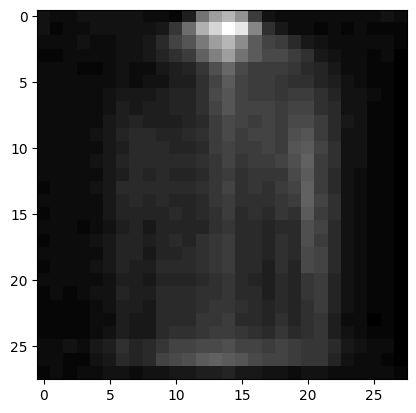

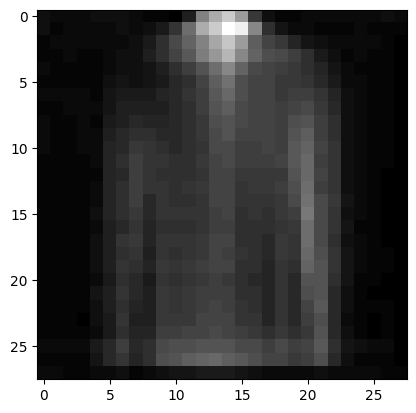

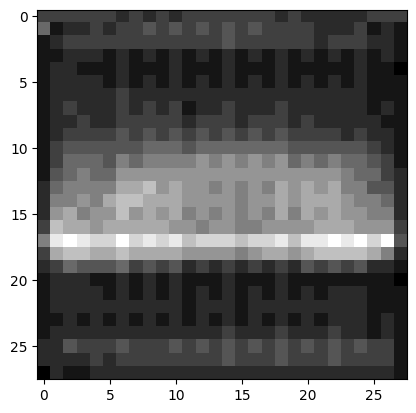

Loss: 0.02339191362261772
Loss: 0.024532802402973175
Loss: 0.021188488230109215
Loss: 0.03384368121623993
Loss: 0.028399746865034103


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

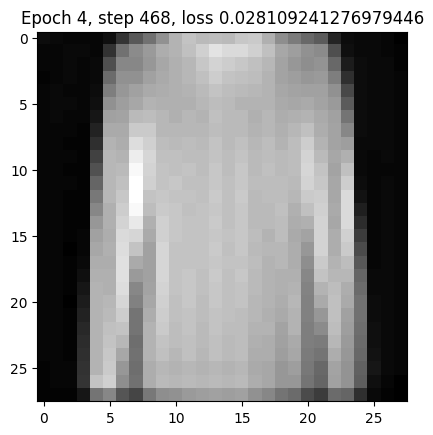

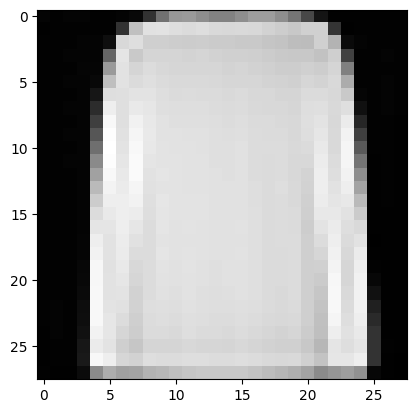

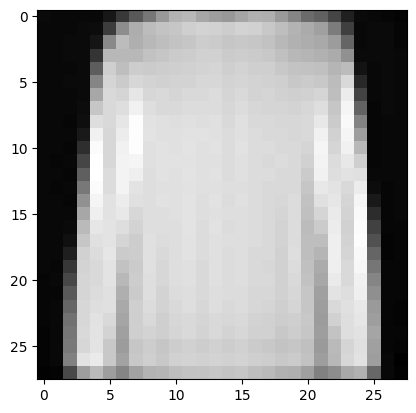

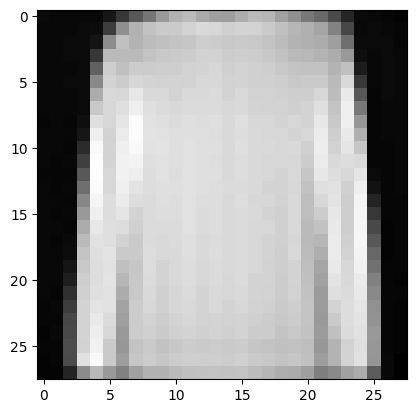

Loss: 0.022768652066588402
Loss: 0.028074191883206367
Loss: 0.024675726890563965
Loss: 0.028249196708202362
Loss: 0.02989550493657589


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

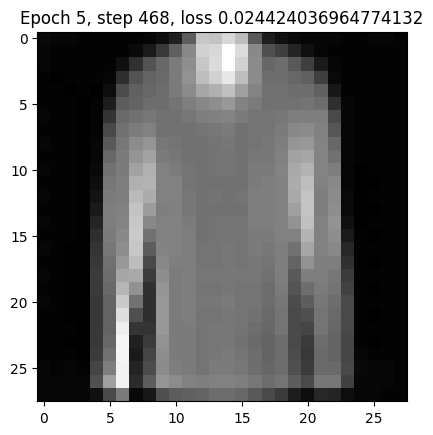

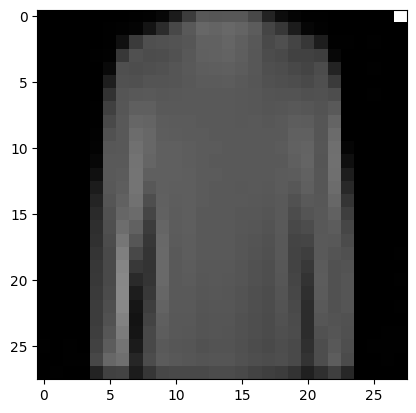

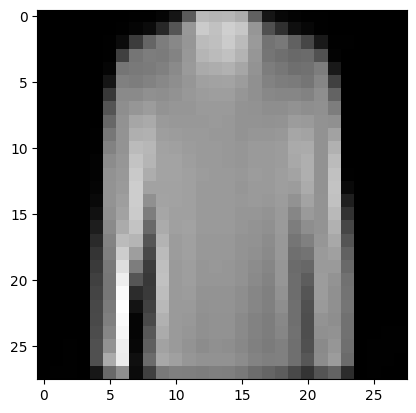

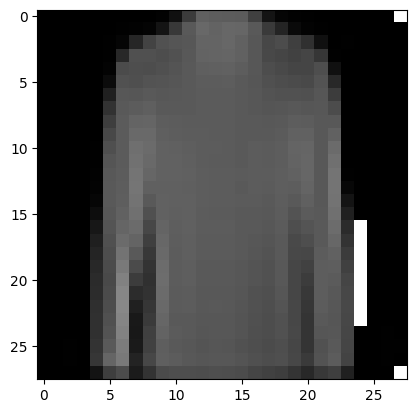

Loss: 0.027489248663187027
Loss: 0.0355975367128849
Loss: 0.023644505068659782
Loss: 0.025544539093971252
Loss: 0.024994531646370888


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

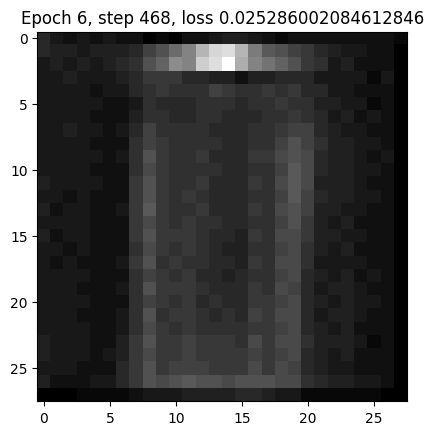

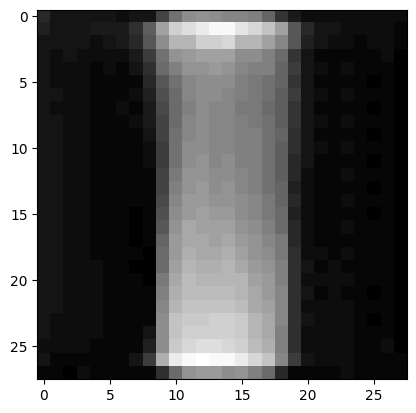

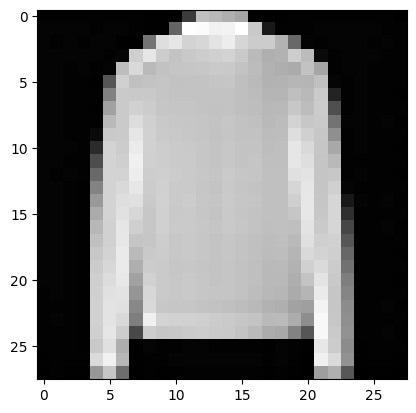

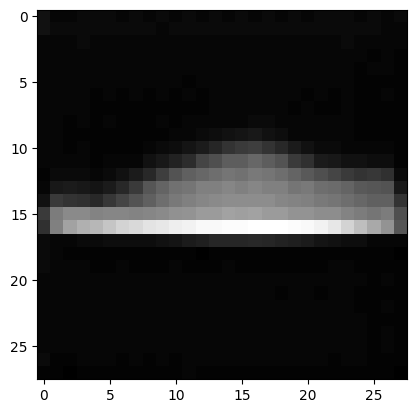

Loss: 0.026071688160300255
Loss: 0.025087540969252586
Loss: 0.021925242617726326
Loss: 0.025599932298064232
Loss: 0.031452726572752


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

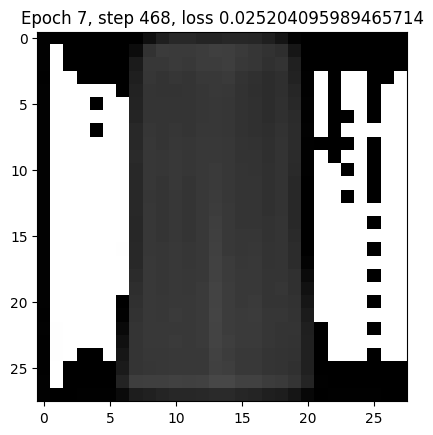

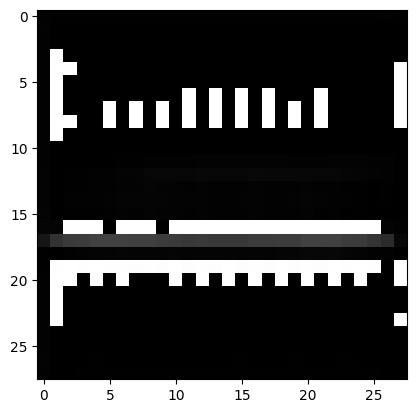

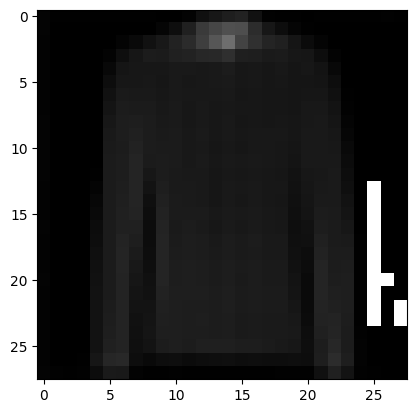

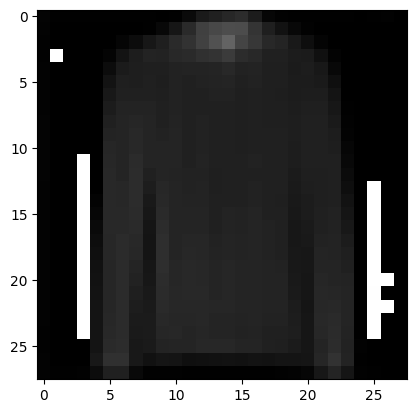

Loss: 0.02646675333380699
Loss: 0.021446608006954193
Loss: 0.024207694455981255
Loss: 0.018792899325489998
Loss: 0.027599232271313667


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

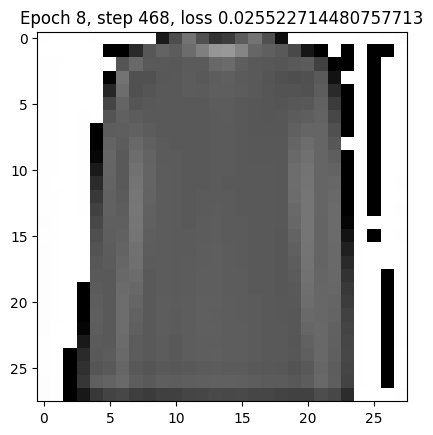

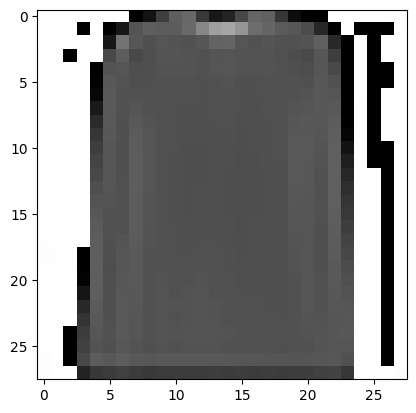

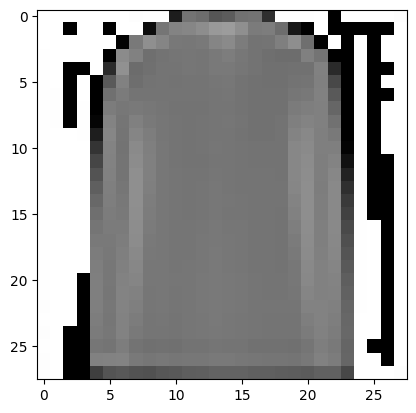

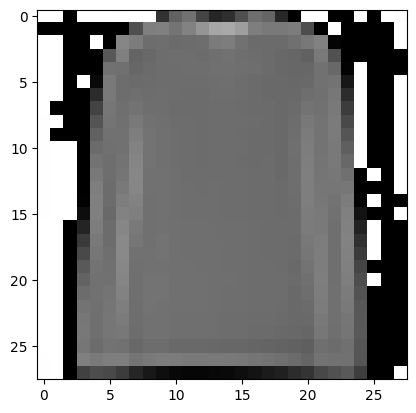

Loss: 0.023617634549736977
Loss: 0.02537287399172783
Loss: 0.026440532878041267
Loss: 0.025386031717061996
Loss: 0.031852226704359055


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

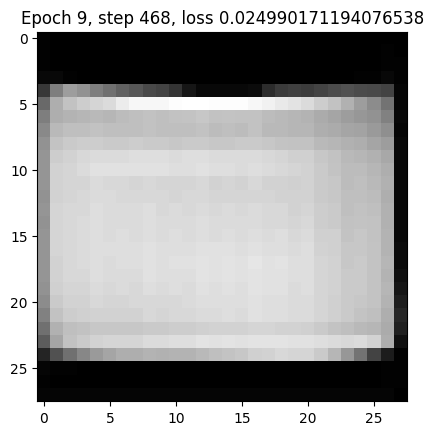

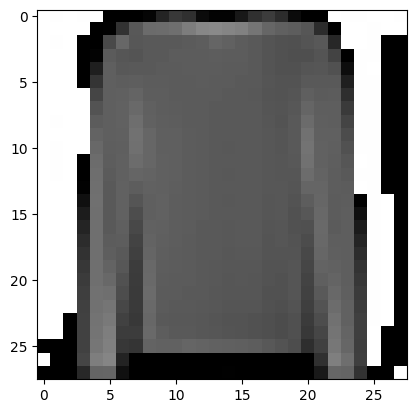

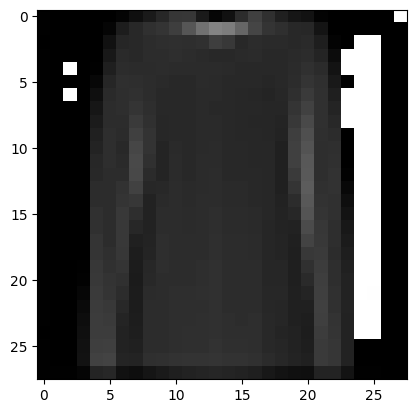

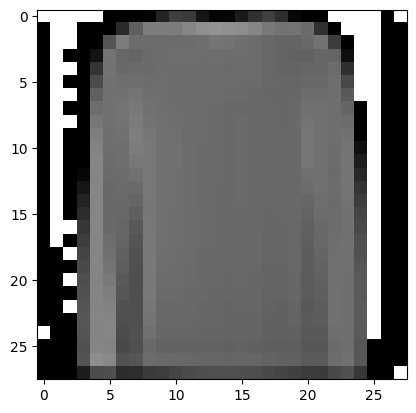

Loss: 0.029353495687246323
Loss: 0.022136079147458076
Loss: 0.02508588694036007
Loss: 0.03012940287590027
Loss: 0.028873056173324585


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

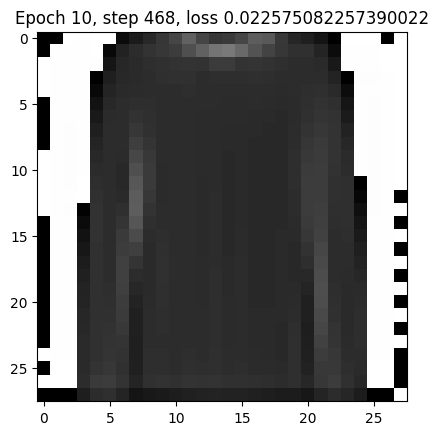

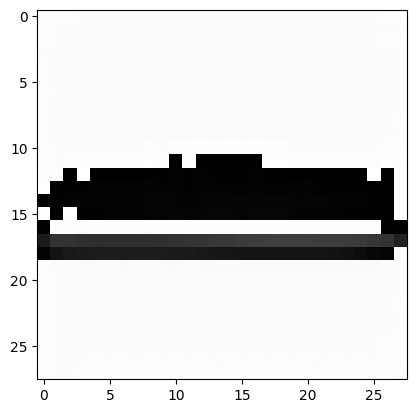

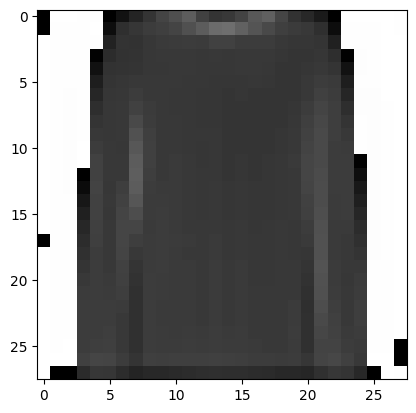

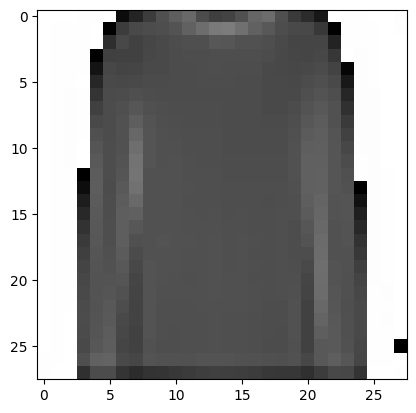

Loss: 0.030499594286084175
Loss: 0.023076223209500313
Loss: 0.02794080786406994
Loss: 0.030765168368816376
Loss: 0.024264615029096603


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

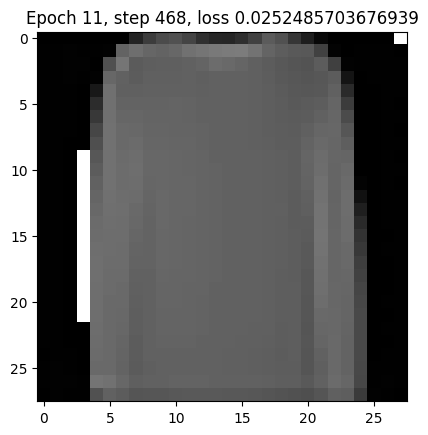

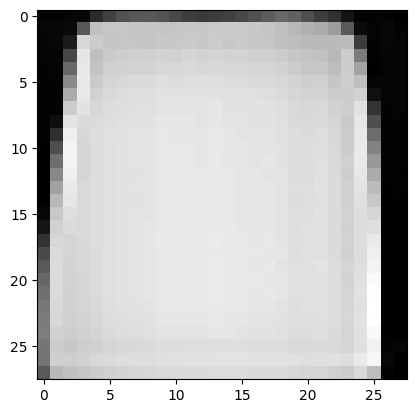

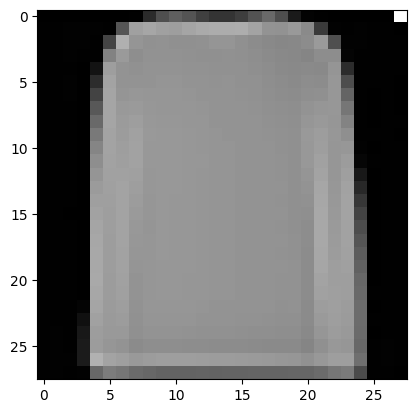

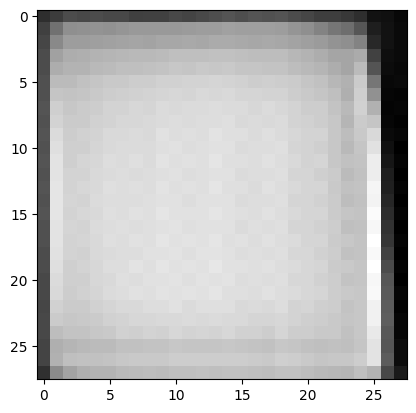

Loss: 0.02523762360215187
Loss: 0.022092346101999283
Loss: 0.01988660730421543
Loss: 0.025273030623793602
Loss: 0.020436998456716537


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

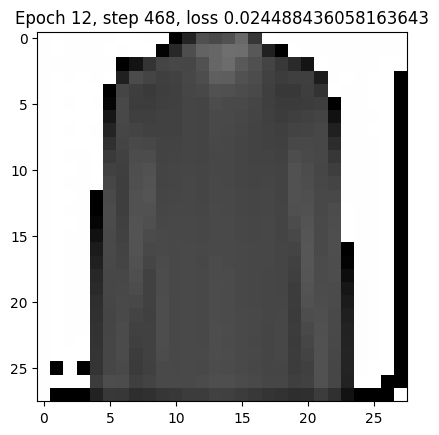

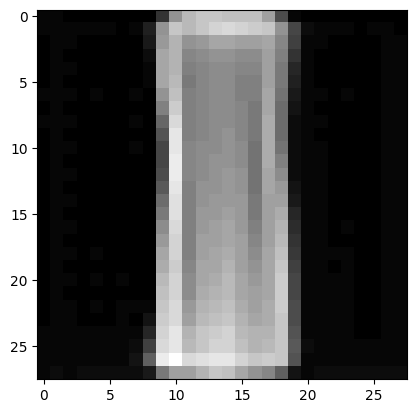

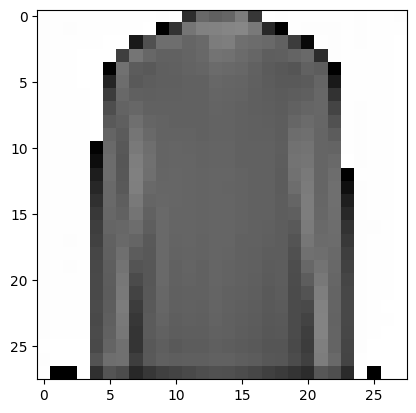

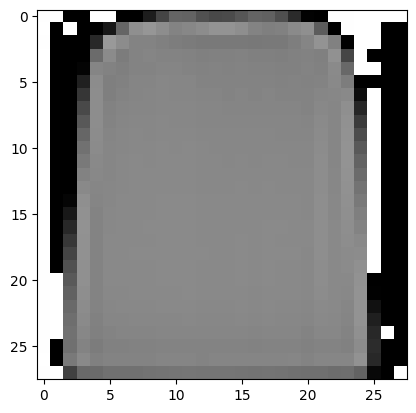

Loss: 0.029913324862718582
Loss: 0.02588687092065811
Loss: 0.027560578659176826
Loss: 0.020159756764769554
Loss: 0.026865104213356972


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

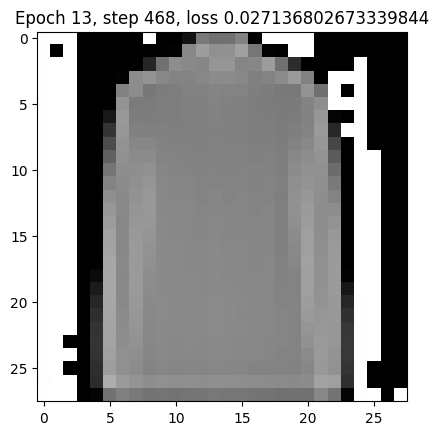

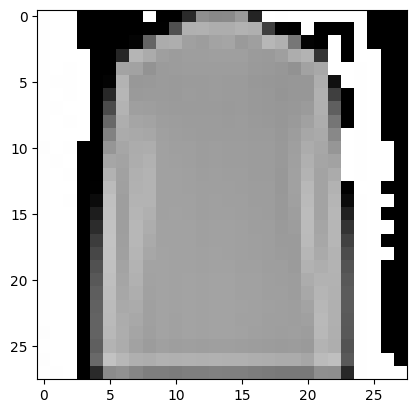

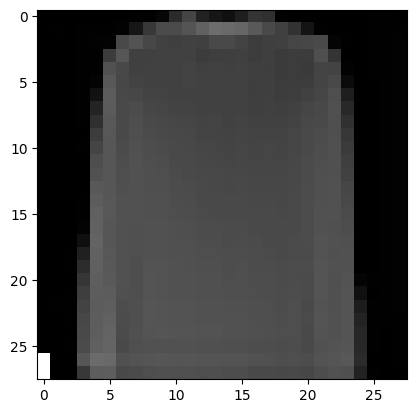

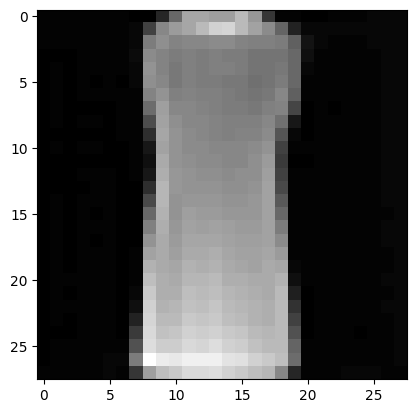

Loss: 0.02469519153237343
Loss: 0.027175121009349823
Loss: 0.023237792775034904
Loss: 0.02296280302107334
Loss: 0.02339026890695095


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

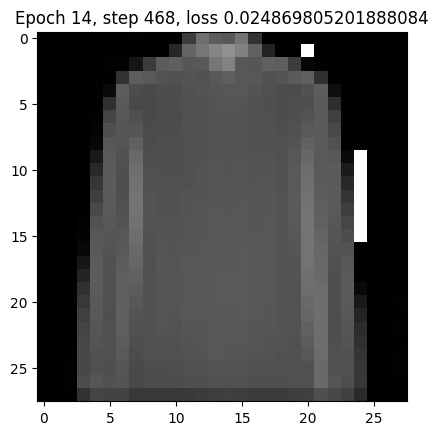

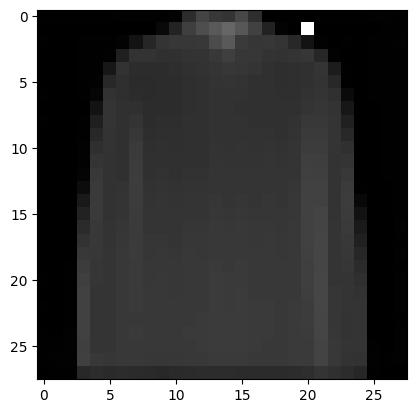

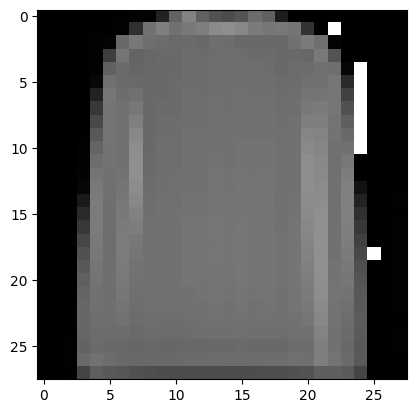

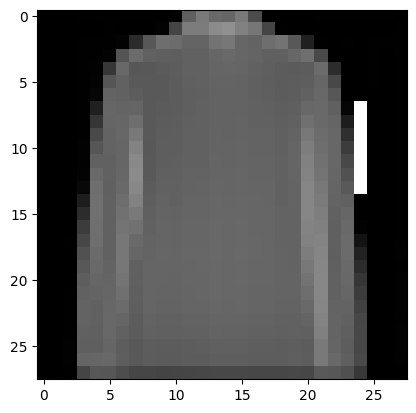

Loss: 0.020469358190894127
Loss: 0.023348433896899223
Loss: 0.0263940691947937
Loss: 0.02710547111928463
Loss: 0.02360318787395954


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

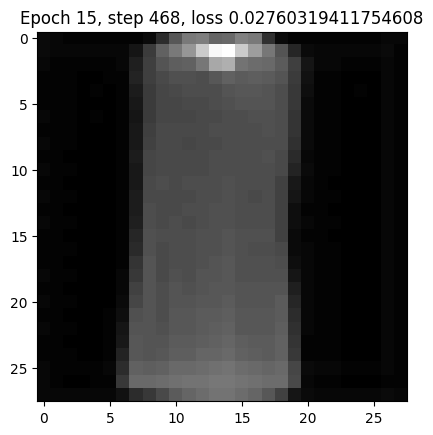

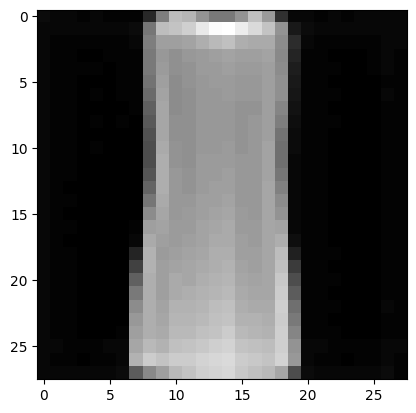

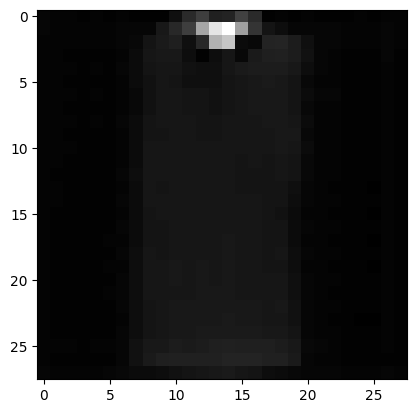

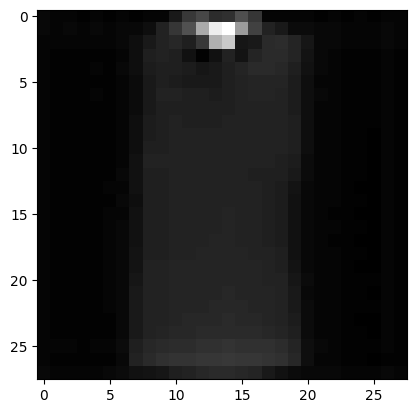

Loss: 0.026098735630512238
Loss: 0.020046500489115715
Loss: 0.028745343908667564
Loss: 0.0186851155012846
Loss: 0.02256077155470848


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

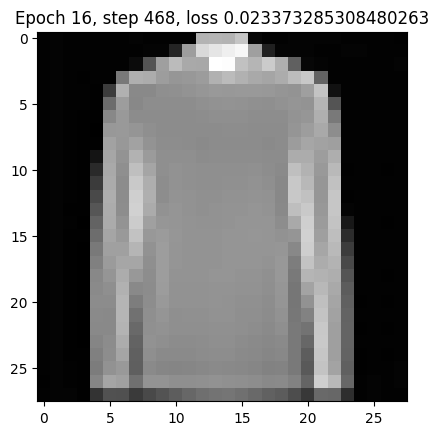

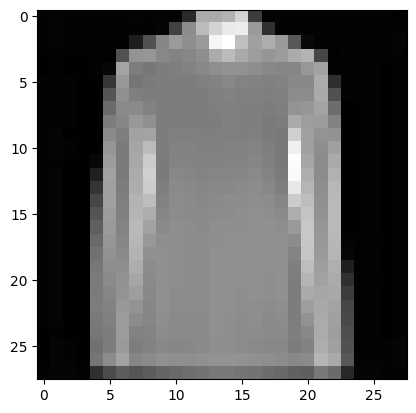

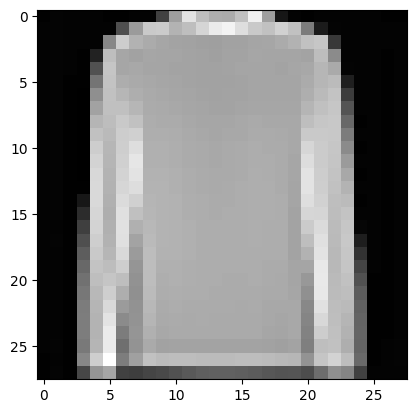

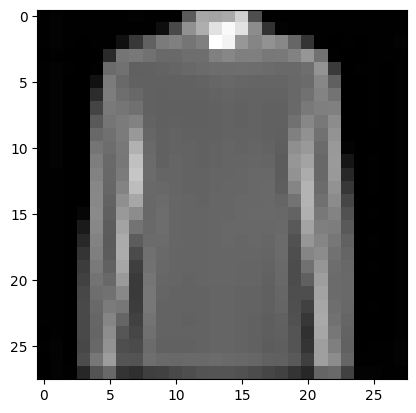

Loss: 0.028013793751597404
Loss: 0.03262767568230629
Loss: 0.02668796479701996
Loss: 0.024837728589773178
Loss: 0.02515450492501259


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

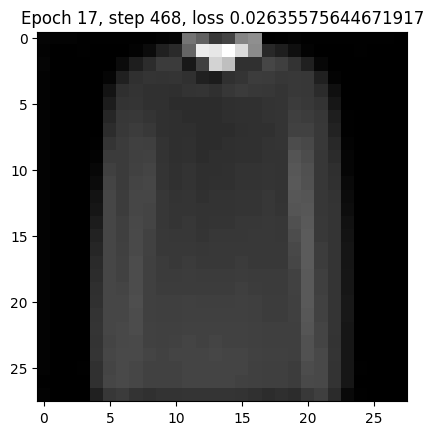

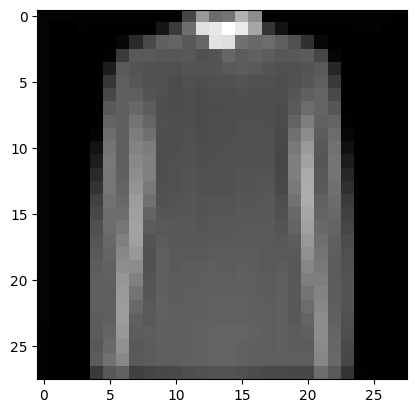

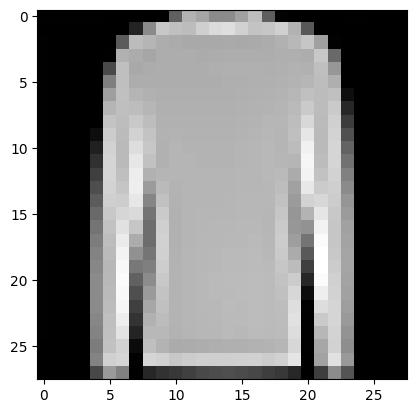

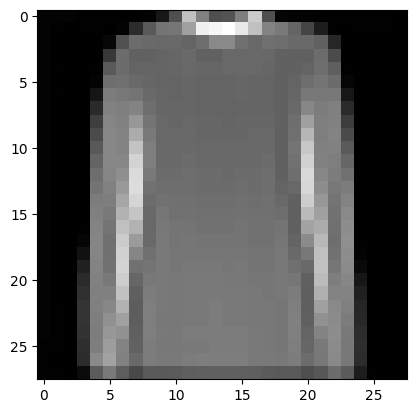

Loss: 0.02579188346862793
Loss: 0.022161994129419327
Loss: 0.025866400450468063
Loss: 0.0270442645996809
Loss: 0.017248859629034996


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

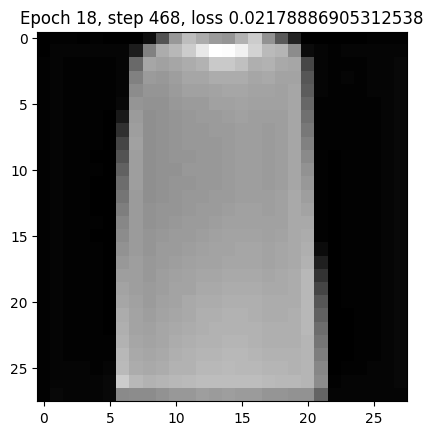

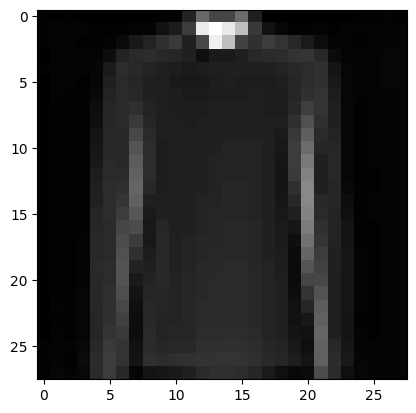

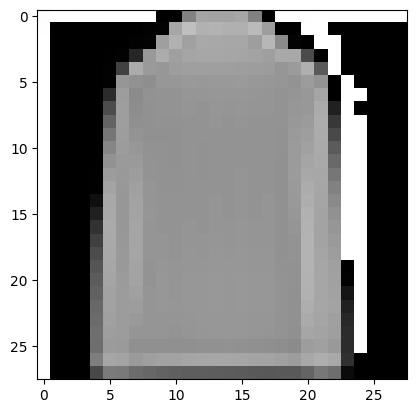

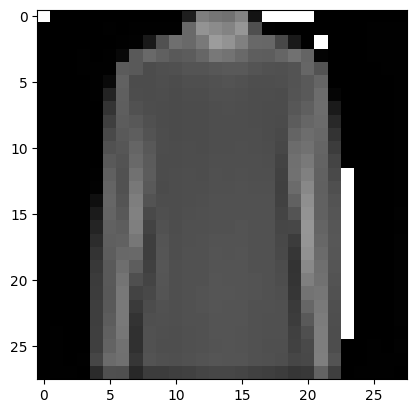

Loss: 0.025267159566283226
Loss: 0.0213569737970829
Loss: 0.030160780996084213
Loss: 0.01784668117761612
Loss: 0.019509613513946533


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

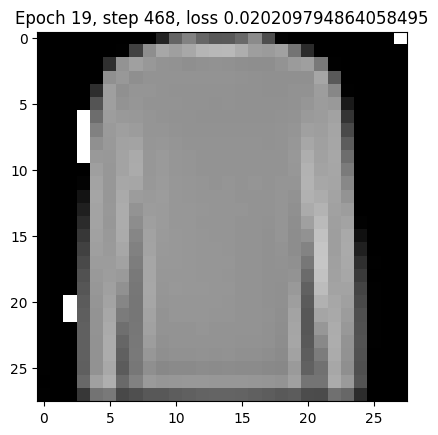

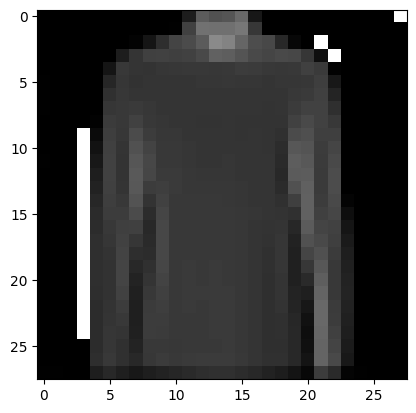

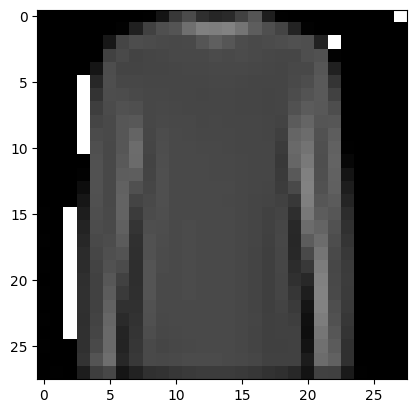

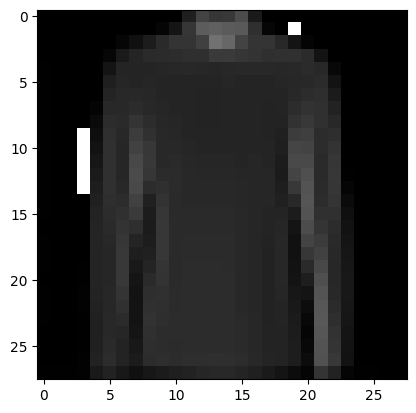

In [26]:
from utils import generate_transform_tensor_to_pil_image

reverse_transform = generate_transform_tensor_to_pil_image()

epochs = 20

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Generate time steps t uniformally (from 0 to timesteps=600 we defined above) for every image in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

    # sample 4 images
    samples = sample(model, image_size=image_size, batch_size=4, channels=channels)

    # show random ones during train
    plt.title(f"Epoch {epoch}, step {step}, loss {loss.item()}")
    for i in range(4):
        plt.imshow(reverse_transform(torch.from_numpy(samples[-1][i])), cmap="gray")
        plt.show()

## Test The Model

sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

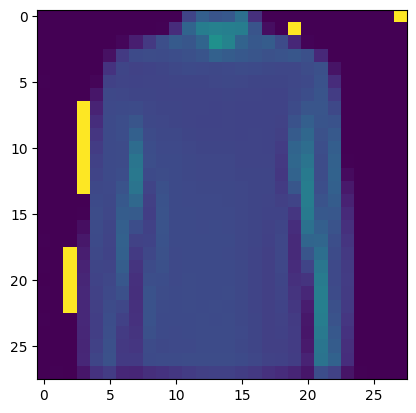

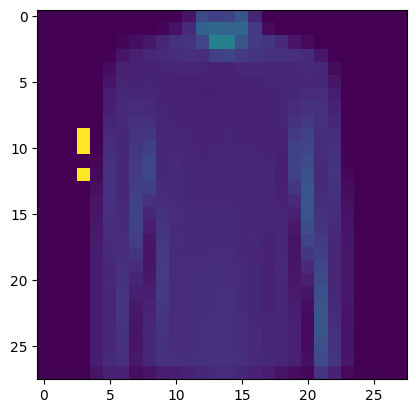

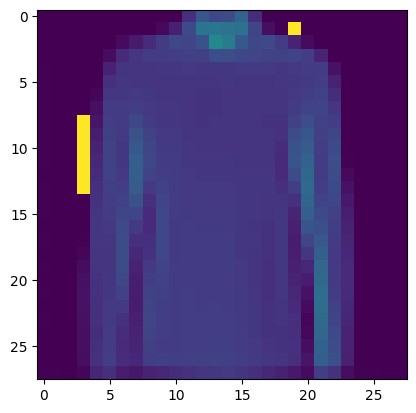

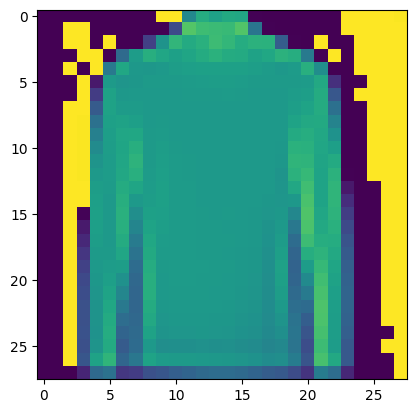

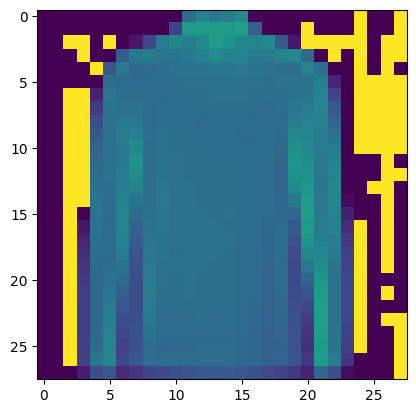

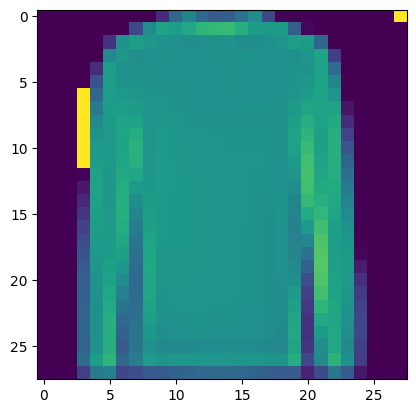

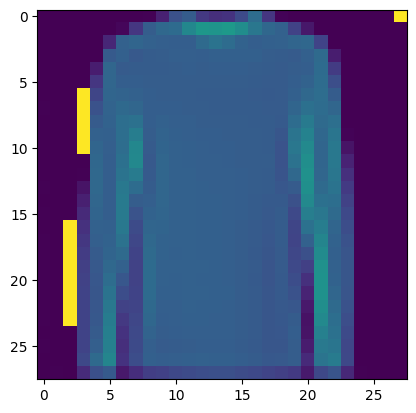

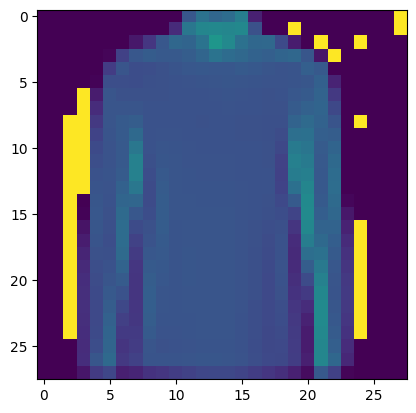

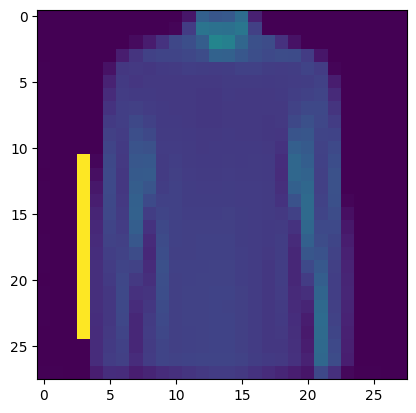

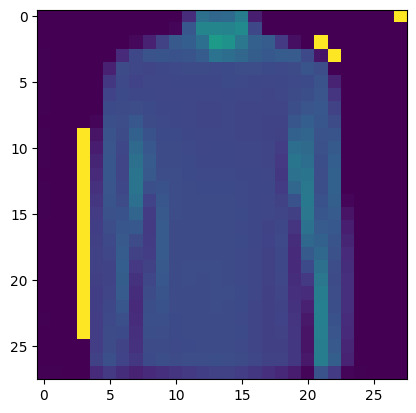

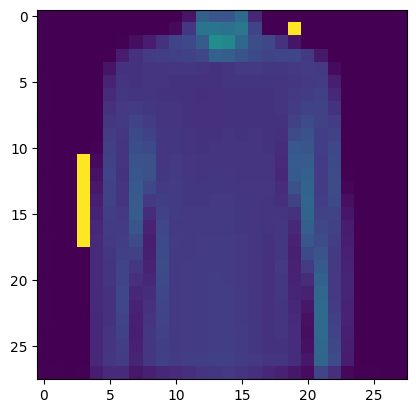

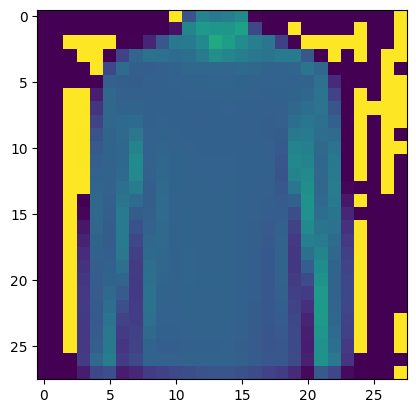

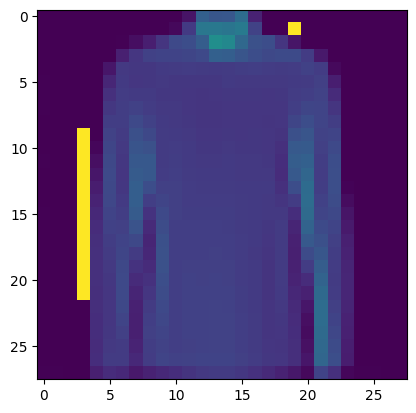

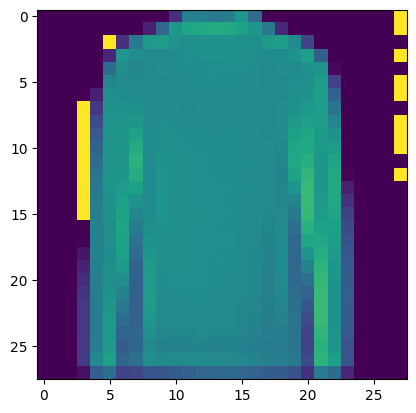

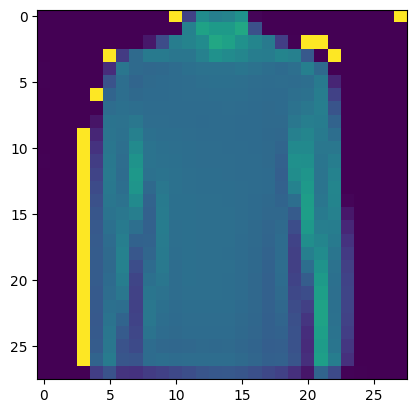

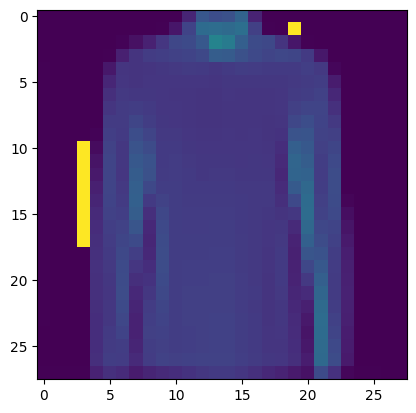

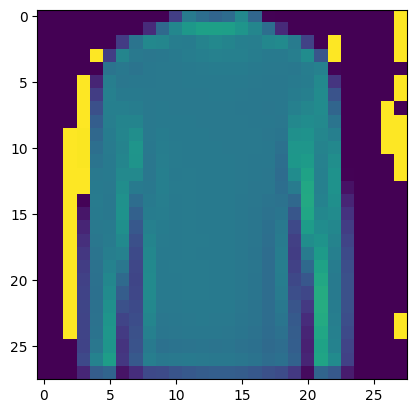

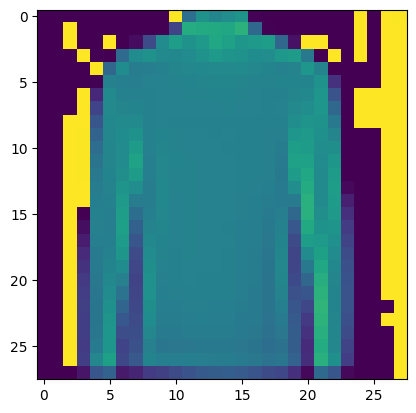

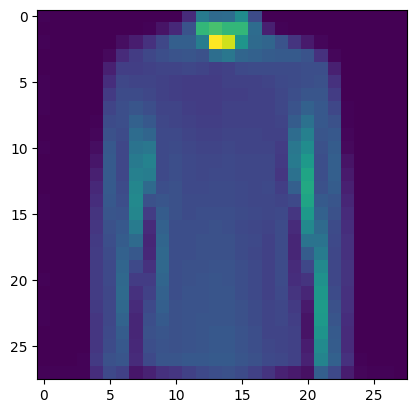

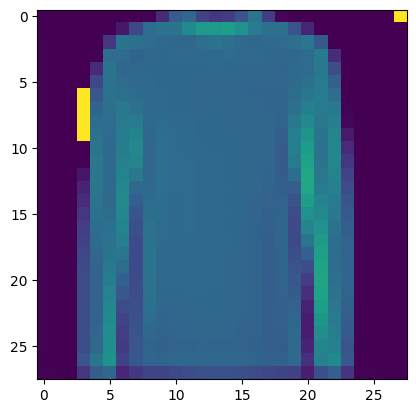

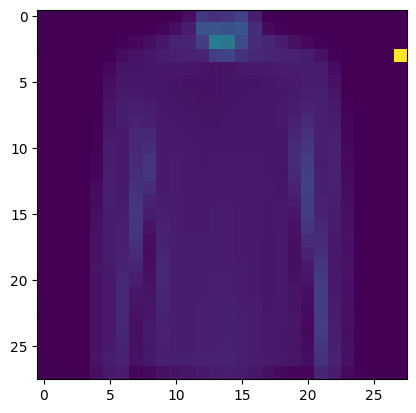

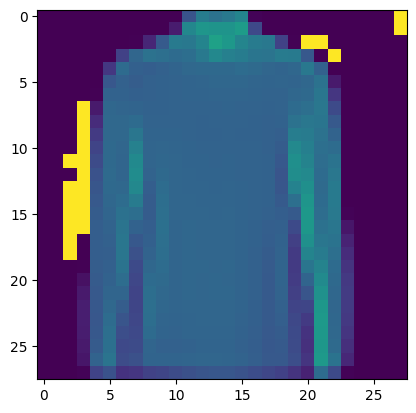

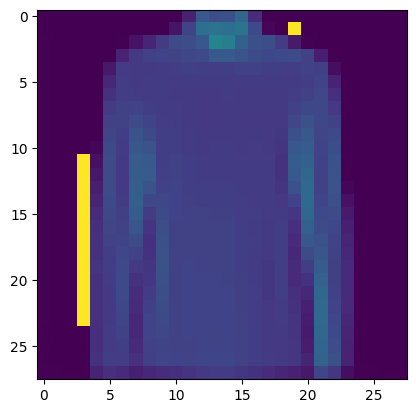

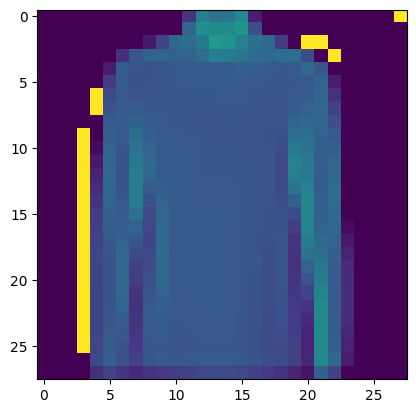

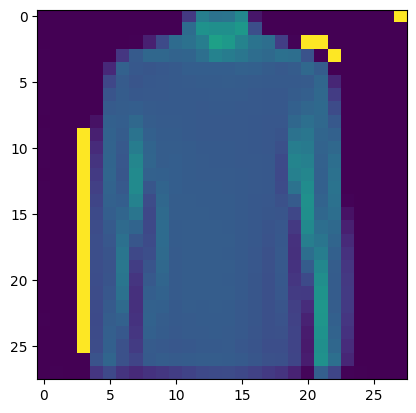

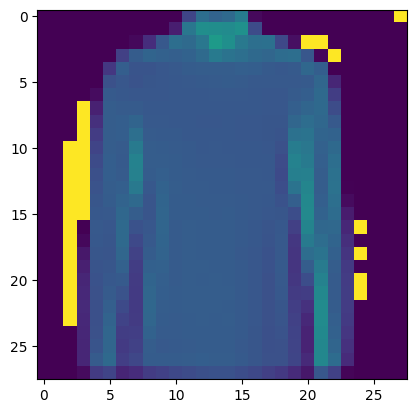

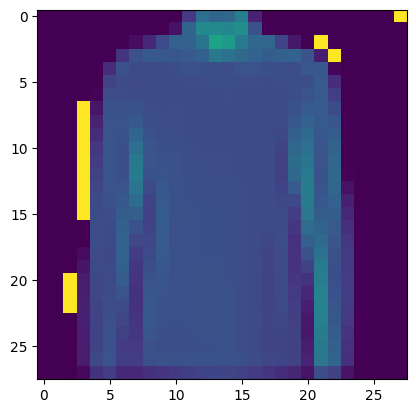

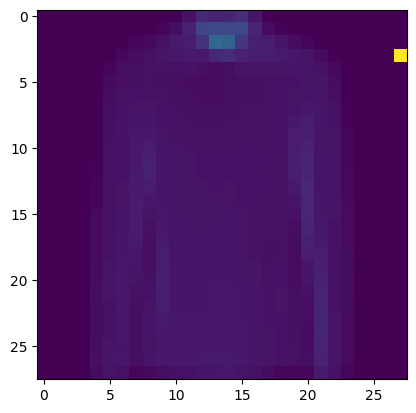

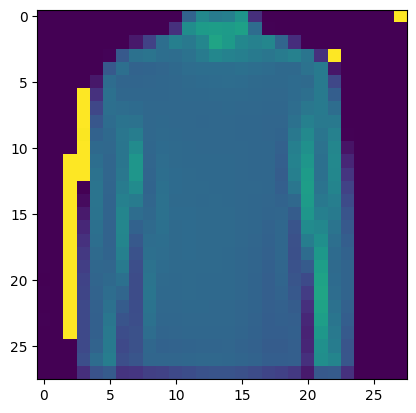

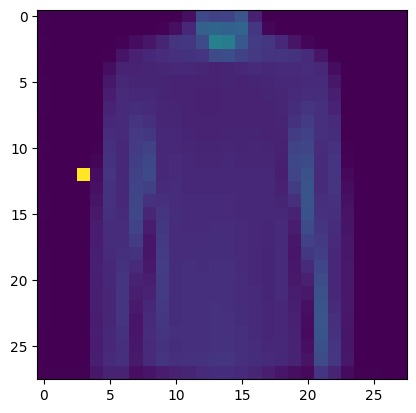

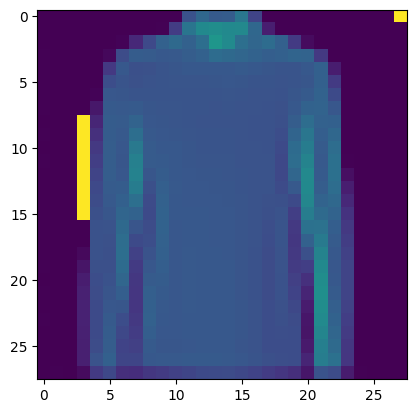

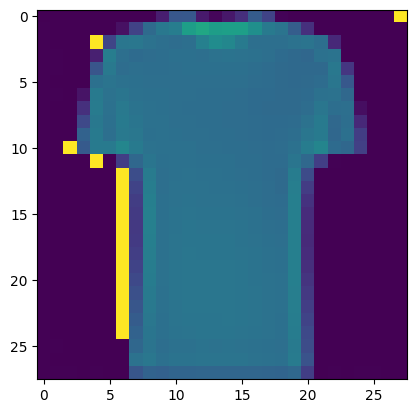

In [27]:
# sample images
bs = 32

samples = sample(model, image_size=image_size, batch_size=bs, channels=channels)

# show random ones
for i in range(bs):
    plt.imshow(reverse_transform(torch.from_numpy(samples[-1][i])))
    plt.show()